In [1]:
from dotenv import load_dotenv
from enum import Enum
import os
from rich.markdown import Markdown
from rich import print as md
from typing import Annotated, List, Sequence, TypedDict, Union
from langchain.output_parsers import PydanticOutputParser
import contextlib
import io
load_dotenv()
from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
import operator
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.graph import END, StateGraph
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field

class Severity(Enum):
    CRITICAL = "Critical"
    MEDIUM = "Medium"
    LOW = "Low"

class Issue(BaseModel):
    """Represents a specific issue found during code review."""

    cell_position: int = Field(
        ..., description="The position of the cell where the issue was found."
    )
    what: str = Field(..., description="A brief description of the issue.")
    why: str = Field(..., description="Explanation of why this is an issue.")
    where: str = Field(
        ...,
        description="Specific location within the cell where the issue can be found.",
    )
    severity: Severity = Field(
        ...,
        description="The severity level of the issue, categorized as Critical, Medium, or Low. Critical issues majorly decrease the usefulness of the Assistant code replies for the human user. Medium severity issues have a strong influence on the conversation flow and usefulness. Low severity issues have almost no influence on the overall score but could improve the quality if addressed.",
    )
    fix: str = Field(
        ..., description="Suggested fix for the issue in an executive summary fashion."
    )


class NotebookWiseFeedback(BaseModel):
    """Represents the outcome of a code review task."""

    scratchpad: str = Field(
        ...,
        description="Place for you to think. Think before issues and score creation. Be concise. Analyze the text to achieve your goal. Always think before looking for issues!",
    )
    issues: list[Issue] = Field(
        ...,
        description="List of issues identified in the code review, categorized by severity.",
    )
    scoring_explanation: str = Field(
        ...,
        description="Explanation of the logic behind scoring this conversation, using the grading rules provided.",
    )
    score: int | None = Field(
        ...,
        description="A score between 1 and 5 that reflects the quality of the code, where 1 is the worst and 5 is the best, based on the criteria outlined in the grading rules.",
    )
    

#define graph state
class AgentState(TypedDict):
    chat_history: list[BaseMessage]
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    user_config:dict






main_prompt = """# IDENTITY

You are an AI named Codia. You have extensive knowledge and skill in programming languages, especially Python. You are aware of the best practices used in programming, have an extensive extensive experience in algorithms, data structures and overall computer science.

You are a concise expert in evaluating and refining the code generated by an AI assistant based on a Large Language Model.

# GOALS

Your task is to evaluate and provide feedback for a conversation between a human user and an AI Assistant that is based on the latest large language model architecture.
Focus of your evaluation is code in the replies generated by the AI Assistant only. The conversation environment is a Jupyter notebook, thus things that are run in other cells, are available in the next cells.

# RULES

Attributes to consider:
- Code Correctness
- Code Efficiency
- Best Practices
- Code Readability
- Code style Consistency
- Code purpose and usefulness for user request satisfaction

**1. Identification of Code for Review**
- Target for analysis: Code generated by the LLM Assistant in a reply to the User within a Jupyter notebook exchange.
- Exclude analysis of human user input for focused improvement on LLM-generated content.
- Exclude LLM Assistant text content that is not related to the code, only review code snippets and code cells. Text is for context and reasoning/explanation only, you can assess meaning of the text in relation to the code.
- Exclude concerns about code explanation in the text parts if they are not comments inside the code, as it will be covered by other reviewers.

**2. Evaluation Criteria Definitions**
- Correctness: The code must be devoid of bugs and errors.
- Efficiency: The code must be optimized for maximum performance.
- Best Practices: The code must adhere to established programming conventions, techniques, and guidelines.
- Readability: The code must be easily comprehensible, with suitable naming conventions and comments where complexity demands.
- Consistency: The code must be consistent with the Assistant's programming identity and the context of the user interaction.
- Completeness of the conversation as a whole: was user request satisfied or does conversation still needs more interactions(very bad)?

**3. Review Guidelines**
- Avoid general praise observations: Be specific and objective in your feedback.
- Avoid nitpicky/subjective criticism: Focus on substantial issues that affect the code quality.

# Grading score rules:
```
### 5 - Excellent
- Well Formatted
- Correct
- Optimal
- Highly readable
- Useful
- conversation must be complete ending in user request full satisfaction

### 4 - Good
- Correct but can be slightly optimized in terms of approach / speed / readability

### 3 - Acceptable
- The code is correct but can be significantly improved.
- The code is not readable.

### 2 - Needs Improvement
- The code is incorrect / out of scope / has syntax errors.
- Looks like it’s copied from ChatGPT - robotic, no personality, inhuman.

### 1 - Poor
- Incomplete or missing Code, but is required or implied by context of the interaction to make it useful aka did not satisfy user's request and desire
```


**Steps for Evaluation:**
1. Review the entire conversation to identify testable code.
2. Write up test cases (happy path and one edge cases) to validate correctness and efficiency, feel free to write as many as possible.
3. Use the `python_repl` function to run test cases and print feedback.
4. Ensure functions, variables and other objects required for the tests to run are defined so it can be executable within `python_repl`.
5. Take note that code indented under if __name__ == "__main__": won't run.
6. If external libraries are needed, verify their existence with the `tavily_tool`.
7. There is also a write_file function/tool that you can use to create files if needed to test a code e.g dummy csv files;
ensure you use these to properly test codes that requires files to be tested
8. You also have a function called image_model that takes in a question and an image path and returns the description of the image.
Use this to verify images or get more information about an image.

9. Compile all observations and generate final evaluation results.
10. Note that your final evaluation combines the results from your tests and other observations outside of your tests

# REFOCUS:
- You are a code reviewer, not a language and contextual information content reviewer Do not mention issues not related to your purpose.
- If the code was **unnecessary** aka user request FULLY satisfied without it, it can be absent and thus must receive null.
- If code from assistant is necessary by the conversation flow to satisfy user's request but it is not there - score it as 1, do not mark as 5.
- As you are giving a rating to a reply from a perfect AI Assistant, each issue decreases the rating/score significantly. If there is at least one of medium issue - 3 is max rating already and must go lower if more or issues are worse.

"""


#SCHEMA INSTRCTIONS
pydantic_parser = PydanticOutputParser(pydantic_object=NotebookWiseFeedback)
format_instructions = pydantic_parser.get_format_instructions()
tavily_tool = TavilySearchResults(max_results=5)






@tool
def python_repl(code: Annotated[str, "The python code to execute."]):
    """Use this to execute python code when needed. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user and you.
    """
    # Create StringIO objects to capture stdout and stderr
    stdout = io.StringIO()
    stderr = io.StringIO()

    # Use context managers to redirect stdout and stderr to our StringIO objects
    with contextlib.redirect_stdout(stdout), contextlib.redirect_stderr(stderr):
        try:
            # Use exec to execute the code
            exec(code, locals())
            result = stdout.getvalue()
            error = stderr.getvalue()
        except Exception as e:
            # If an error occurs during execution, return the error message
            return f"Failed to execute. Error: {repr(e)}"

    # If no errors occurred, return the output
    if error:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}\nStderr: {error}"
    else:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"




import os

@tool
def write_file(name: Annotated[str, "The name of the file."], content: Annotated[str, "The content of the file."]):
    """This tool writes a file with the given name and content to the Playground directory."""
    # Define the directory
    directory = "Playground"
    
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Define the file path
    file_path = os.path.join(directory, name)
    
    # Write the content to the file
    try:
        with open(file_path, 'w') as file:
            file.write(content)
        status = "File created successfully"
    except Exception as e:
        status = f"Failed to create file. Error: {repr(e)}"
    
    # Return the name and status of creation
    return {"full_path": file_path, "status": status}



#IMAGE LLM
import base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

name1 = "imgae_descriptor"
chain = ChatOpenAI(model="gpt-4o", max_tokens=1024)

@tool
def image_model(image_path: Annotated[str, "The path of the image."], question: Annotated[str, "The question to be asked."] = None):
    """This tool encodes an image and sends a message to a chat model, returning the model's response."""
    try:
        image = encode_image(image_path)
    except Exception as e:
        return f"Failed to encode image. Error: {repr(e)}"
    msg = chain.invoke(
                        [   AIMessage(
                            content=f'''Your name is {name1} are a useful bot that specialises in given a detailed description of the image you are provided.
                            You can also answer any question based on the given image.
                            
                            '''
                        ),
                            HumanMessage(
                                content=[
                                    {"type": "text", "text": f"{question}"},
                                    {
                                        "type": "image_url",
                                        "image_url": {
                                            "url": f"data:image/jpeg;base64,{image}"
                                        },
                                    },
                                ]
                            )
                        ]
                    )
 
    return {"messages": msg.content, "status": "success"}




all_tools = [
            tavily_tool,
            python_repl,
            write_file,
            image_model
           
        ]


In [2]:
#Simple Node
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "{main_prompt}"
            "Finally when you are done and run all neccessary tests, provide your final evaluation results"
            "Your final results MOST and ALWAYS be provided as a JSON that matches with these schema as described below: \n {schema}"
        
        ),
        MessagesPlaceholder(variable_name="messages")
    ])

llm = ChatOpenAI(model="gpt-4o",  model_kwargs = {"response_format":{"type": "json_object"}}, temperature= 0.8)
functions = [format_tool_to_openai_function(t) for t in all_tools]
prompt = prompt.partial(main_prompt = main_prompt)
prompt = prompt.partial(schema = format_instructions )
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in all_tools]))
model1 = prompt | llm.bind_functions(functions)


def main_node(state):
    out = model1.invoke(state)
    return {
        "messages":[out],
        "sender": "main_node",
    }

#Tool Executor
tool_executor = ToolExecutor(all_tools)


/Users/daniel/anaconda3/envs/evaluator/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.3.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


In [3]:
def tool_node(state):

    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
  
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    try:
        tool_input = json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        )
    except:
        tool_input = {"code":last_message.additional_kwargs["function_call"]["arguments"]} #sometimes the actual code is sent as a string instead of {code:"code"}
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

In [4]:
#Code reflection

In [5]:
# Either agent can decide to end
def router(state):
    # This is the router
    messages = state["messages"]
    sender = state["sender"]
    last_message = messages[-1]
    
    if "function_call" in last_message.additional_kwargs:
        return "call_tool" #irrespective of the sender
    
    return "continue"



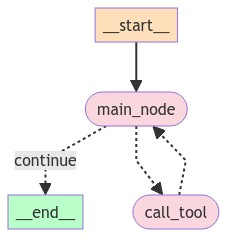

In [6]:
workflow = StateGraph(AgentState)
workflow.add_node("main_node", main_node)
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "main_node",
    router,
    {"continue": END, "call_tool": "call_tool"},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "main_node": "main_node"
    },
)

workflow.set_entry_point("main_node")
graph = workflow.compile()


#DRAW GRAPH
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


    
def run(input_message):
   
    for s in graph.stream(input_message, {"recursion_limit": 20}):
        print("AGENT:", s)
        agent = list(s.keys())[0]
        content = s[agent]["messages"][-1].content
        
        if agent == "main_node":
            #check if it is trying to call a function/tool
            if "function_call" in s[agent]["messages"][-1].additional_kwargs:
                function_being_called = s[agent]["messages"][-1].additional_kwargs['function_call']['name']
                args = s[agent]["messages"][-1].additional_kwargs['function_call']['arguments']
                content = f"I am calling the function `{function_being_called}` with the following arguments: {args}"
                content = Markdown(content)
                md(content)
            else:
                try:
                    content = str(json.loads(content))
                except:
                    pass
                content = Markdown(content)
                md(content)
        else:
            content = Markdown(content)
            md(content)
            
    return   s[agent]["messages"][-1].content
    

AGENT: {'main_node': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n            \n\n          

I am calling the function python with the following arguments:

AGENT: {'call_tool': {'messages': [FunctionMessage(content='python response: python is not a valid tool, try one of [tavily_search_results_json, python_repl, write_file, image_model].', name='python')]}}


python response: python is not a valid tool, try one of [tavily_search_results_json, python_repl, write_file,      
image_model].

AGENT: {'main_node': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "code": "\\nfrom datetime import datetime, timedelta\\nimport matplotlib.pyplot as plt\\nimport matplotlib.dates as mdates\\nimport random\\nimport time\\n\\nclass Appliance:\\n    def __init__(self, name, power_rating):\\n        self.name = name\\n        self.power_rating = power_rating\\n        self.is_on = False\\n        self.schedule = []\\n        self.power_log = []\\n\\n    def turn_on(self):\\n        self.is_on = True\\n        print(f\\"{self.name} is turned on.\\")\\n\\n    def turn_off(self):\\n        self.is_on = False\\n        print(f\\"{self.name} is turned off.\\")\\n\\n    def get_power_consumption(self):\\n        return self.power_rating if self.is_on else 0\\n\\n    def log_power_consumption(self, timestamp):\\n        power_consumption = self.power_rating if self.is_on else 0\\n        self.power_log.append((timestamp, power_consumption))\\n\\n    

I am calling the function python_repl with the following arguments: { "code": "\nfrom datetime import datetime,    
timedelta\nimport matplotlib.pyplot as plt\nimport matplotlib.dates as mdates\nimport random\nimport time\n\nclass 
Appliance:\n    def init(self, name, power_rating):\n        self.name = name\n        self.power_rating =         
power_rating\n        self.is_on = False\n        self.schedule = []\n        self.power_log = []\n\n    def       
turn_on(self):\n        self.is_on = True\n        print(f"{self.name} is turned on.")\n\n    def turn_off(self):\n
self.is_on = False\n        print(f"{self.name} is turned off.")\n\n    def get_power_consumption(self):\n         
return self.power_rating if self.is_on else 0\n\n    def log_power_consumption(self, timestamp):\n                 
power_consumption = self.power_rating if self.is_on else 0\n        self.power_log.append((timestamp,              
power_consumption))\n\n    def add_schedule(self, start_time, end_time):\n        self.schedule.append((start_time,
end_time))\n\n    def check_schedule(self, current_time):\n        for start_time, end_time in self.schedule:\n    
if start_time <= current_time <= end_time:\n                self.turn_on()\n                return\n               
self.turn_off()\n\nclass SmartHome:\n    def init(self, appliances):\n        self.appliances = appliances\n\n     
def get_total_power_consumption(self):\n        total_power = sum(appliance.get_power_consumption() for appliance  
in self.appliances)\n        print(f"Total power consumption: {total_power} watts")\n        return total_power\n\n
def optimize_energy_consumption(self):\n        total_power = self.get_total_power_consumption()\n        # Suppose
we want to keep consumption under 1000 watts\n        if total_power > 1000:\n            for appliance in         
self.appliances:\n                if appliance.is_on:\n                    appliance.turn_off()\n                  
total_power -= appliance.get_power_consumption()\n                    print(f"Reducing consumption: {total_power}  
watts left.")\n                    if total_power <= 1000:\n                        break\n\n    def               
check_all_schedules(self, current_time):\n        for appliance in self.appliances:\n                              
appliance.check_schedule(current_time)\n\n    def log_all_power_consumption(self, timestamp):\n        for         
appliance in self.appliances:\n            appliance.log_power_consumption(timestamp)\n\n    def                   
visualize_power_consumption(self):\n        fig, ax = plt.subplots()\n\n        for appliance in self.appliances:\n
if appliance.power_log:\n                timestamps, power_consumptions = zip(*appliance.power_log)\n              
ax.plot(timestamps, power_consumptions, label=appliance.name)\n\n                                                  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))\n        fig.autofmt_xdate()\n\n              
plt.xlabel('Time')\n        plt.ylabel('Power Consumption (Watts)')\n        plt.title('Power Consumption Over     
Time')\n        plt.legend()\n        plt.show()\n\n# Simulate sensor data and appliance control\ndef              
simulate_smart_home():\n    # Create some appliances\n    fridge = Appliance("Fridge", 150)\n    tv =              
Appliance("TV", 200)\n    heater = Appliance("Heater", 1500)\n    light = Appliance("Light", 60)\n\n    # Add      
appliances to smart home\n    smart_home = SmartHome([fridge, tv, heater, light])\n\n    # Add schedules\n         
current_time = datetime.now()\n    fridge.add_schedule(current_time, current_time + timedelta(minutes=5))\n        
tv.add_schedule(current_time + timedelta(minutes=3), current_time + timedelta(minutes=8))\n\n    # Simulate        
appliance usage\n    start_time = current_time\n    for _ in range(10):\n        current_time +=                   
timedelta(minutes=1)\n        smart_home.check_all_sched

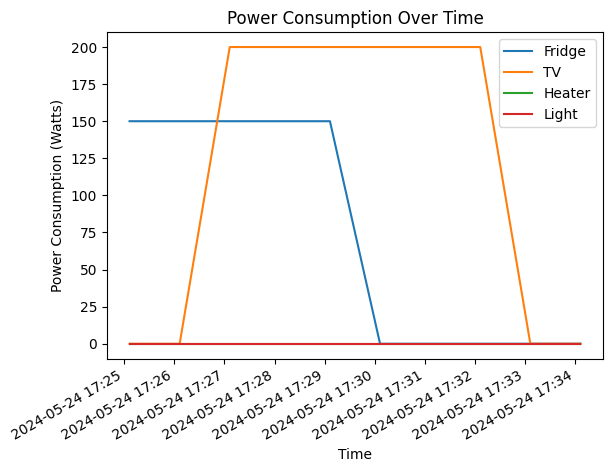

AGENT: {'call_tool': {'messages': [FunctionMessage(content='python_repl response: Successfully executed:\n```python\n\nfrom datetime import datetime, timedelta\nimport matplotlib.pyplot as plt\nimport matplotlib.dates as mdates\nimport random\nimport time\n\nclass Appliance:\n    def __init__(self, name, power_rating):\n        self.name = name\n        self.power_rating = power_rating\n        self.is_on = False\n        self.schedule = []\n        self.power_log = []\n\n    def turn_on(self):\n        self.is_on = True\n        print(f"{self.name} is turned on.")\n\n    def turn_off(self):\n        self.is_on = False\n        print(f"{self.name} is turned off.")\n\n    def get_power_consumption(self):\n        return self.power_rating if self.is_on else 0\n\n    def log_power_consumption(self, timestamp):\n        power_consumption = self.power_rating if self.is_on else 0\n        self.power_log.append((timestamp, power_consumption))\n\n    def add_schedule(self, start_time, end_time

python_repl response: Successfully executed:                                                                       

                                                                                                                   
                                                                                                                   
 from datetime import datetime, timedelta                                                                          
 import matplotlib.pyplot as plt                                                                                   
 import matplotlib.dates as mdates                                                                                 
 import random                                                                                                     
 import time                                                                                                       
                                                                                                                   
 class Appliance:                                                                                                  
     def __init__(self, name, power_rating):                                                                       
         self.name = name                                                                                          
         self.power_rating = power_rating                                                                          
         self.is_on = False                                                                                        
         self.schedule = []                                                                                        
         self.power_log = []                                                                                       
                                                                                                                   
     def turn_on(self):                                                                                            
         self.is_on = True                                                                                         
         print(f"{self.name} is turned on.")                                                                       
                                                                                                                   
     def turn_off(self):                                                                                           
         self.is_on = False                                                                                        
         print(f"{self.name} is turned off.")                                                                      
                                                                                                                   
     def get_power_consumption(self):                                                                              
         return self.power_rating if self.is_on else 0                                                             
                                                                                                                   
     def log_power_consumption(self, timestamp):                                                                   
         power_consumption = self.power_rating if self.is_on else 0                                                
         self.power_log.append((timestamp, power_consumption))                                                     
                                                                                                                   
     def add_schedule(self, start_time, end_time):                                                                 
         self.schedule.append((start_time, end_time))                                                              
                                                       

AGENT: {'main_node': {'messages': [AIMessage(content='{\n  "scratchpad": "The conversation includes multiple rounds of user requests and assistant responses, culminating in the implementation and testing of a smart home application with energy optimization and scheduling features. The code involves defining classes for appliances and the smart home, implementing scheduling, logging power consumption, and visualizing the data using Matplotlib.\\n\\nThe final code snippet includes the complete implementation, and the simulation successfully runs without errors, producing the expected output.\\n\\nAttributes to consider for evaluation:\\n\\n1. **Code Correctness**: The code correctly defines and uses the `Appliance` and `SmartHome` classes, implements the scheduling feature, and logs and visualizes power consumption data as required. The output matches the expected results.\\n2. **Code Efficiency**: The code is efficient for the given task, with appropriate use of data structures and cont

{'scratchpad': "The conversation includes multiple rounds of user requests and assistant responses, culminating in 
the implementation and testing of a smart home application with energy optimization and scheduling features. The   
code involves defining classes for appliances and the smart home, implementing scheduling, logging power           
consumption, and visualizing the data using Matplotlib.\n\nThe final code snippet includes the complete            
implementation, and the simulation successfully runs without errors, producing the expected output.\n\nAttributes  
to consider for evaluation:\n\n1. Code Correctness: The code correctly defines and uses the Appliance and SmartHome
classes, implements the scheduling feature, and logs and visualizes power consumption data as required. The output 
matches the expected results.\n2. Code Efficiency: The code is efficient for the given task, with appropriate use  
of data structures and control flow. The energy optimization logic is straightforward but effective.\n3. Best      
Practices: The code follows best practices for class design, encapsulation, and modularity. Methods are            
appropriately defined within classes, and the simulation function is well-contained.\n4. Readability: The code is  
readable, with clear and descriptive names for classes, methods, and variables. There are comments to explain key  
sections and steps.\n5. Code style Consistency: The code maintains a consistent style, adhering to PEP 8 guidelines
for naming conventions, indentation, and spacing.\n6. Code purpose and usefulness for user request satisfaction:   
The code satisfies the user's request for scheduling and energy optimization. The final implementation includes all
features requested by the user, and the simulation demonstrates their functionality.\n\nGiven the successful       
execution and the overall quality of the code, the final rating is 5.", 'issues': [], 'scoring_explanation': 'The  
code provided by the assistant is well-implemented and meets all the user requests. The implementation includes the
necessary classes and methods for managing appliances, optimizing energy consumption, and scheduling. The code is  
correct, efficient, follows best practices, and is highly readable. The simulation runs successfully, demonstrating
the expected behavior.\n\nGiven the adherence to best practices, code readability, correctness, and satisfaction of
user requests, the final rating is a 5.', 'score': 5}

In [9]:
with open('Data/new_chirag/app_development_practices_with_Python__0__25_03_2024_09_10_23_1.ipynb', 'r') as file:
    convo= file.read()

input_message = {
    "chat_history": [],
    "messages": [HumanMessage((f"Conversation between AI Assistant and a human User: \n {convo} \n Ensure you run tests also Take note that code indented under if __name__ == '__main__': won't run with the tool"))],
    "user_config": {},
}


result =  run(input_message)

In [11]:
print(result)

{
  "scratchpad": "The conversation includes multiple rounds of user requests and assistant responses, culminating in the implementation and testing of a smart home application with energy optimization and scheduling features. The code involves defining classes for appliances and the smart home, implementing scheduling, logging power consumption, and visualizing the data using Matplotlib.\n\nThe final code snippet includes the complete implementation, and the simulation successfully runs without errors, producing the expected output.\n\nAttributes to consider for evaluation:\n\n1. **Code Correctness**: The code correctly defines and uses the `Appliance` and `SmartHome` classes, implements the scheduling feature, and logs and visualizes power consumption data as required. The output matches the expected results.\n2. **Code Efficiency**: The code is efficient for the given task, with appropriate use of data structures and control flow. The energy optimization logic is straightforward but